In [1]:
from help_funcs import *
import numpy as np
import os
import scipy.io as spio
from multiprocessing import Pool
from functools import partial
import scipy
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from numpy import dot
from numpy.linalg import norm
import pickle
import matplotlib as mpl
import seaborn as sns
import pandas as pd
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rc('font', family='arial')

alpha=0.01

In [2]:
#load data
sp_data=loadmat('20240122/st_expert.mat')
event_data=loadmat('20240122/et_expert.mat')
behav_data=loadmat('20240122/behavior.mat')

In [3]:
ev_list=['times_vec_hit_easy','times_vec_CR_easy','times_vec_hit_hard','times_vec_CR_hard']

In [4]:
#filter sessions
repeat=1
session_list_ado = []
i=0
for j in range(len(sp_data['st'][i])):
    if len(sp_data['st'][i][j])>20:
        flag=False
        for key in ev_list:
            if len(np.array(event_data['et'][i][j][key]).reshape(-1,1))<20:
                flag=True
                break
        if flag:
            continue
        for _ in range(repeat):
            session_list_ado.append(session(sp_data['st'][i][j],event_data['et'][i][j]))
session_list_adu = []
i=1
for j in range(len(sp_data['st'][i])):
    if len(sp_data['st'][i][j])>20:
        flag=False
        for key in ev_list:
            if len(np.array(event_data['et'][i][j][key]).reshape(-1,1))<20:
                flag=True
                break
        if flag:
            continue
        for _ in range(repeat):
            session_list_adu.append(session(sp_data['st'][i][j],event_data['et'][i][j]))

In [5]:
lda_distance_multisession=partial(lda_distance,event_list=ev_list,
   bin_min=0,bin_max=0.2,n=1,window_size=2,cpu=1,subsample=2000,subsample_event=None)
def temp_func(i):
    return lda_distance_multisession([session_list_adu[i],i])
with Pool(96) as p:
    results_adu=p.map(temp_func,np.arange(len(session_list_adu)))
def temp_func(i):
    return lda_distance_multisession([session_list_ado[i],i])
with Pool(96) as p:
    results_ado=p.map(temp_func,np.arange(len(session_list_ado))[[0,2,3,4,5,6,7]])

In [6]:
hard_adu=((np.array([i[1][1] for i in results_adu])[:,0]-np.array([i[1][1] for i in results_adu])[:,1])**2)/(np.array([i[1][2] for i in results_adu]).sum(axis=-1))
easy_adu=((np.array([i[0][1] for i in results_adu])[:,0]-np.array([i[0][1] for i in results_adu])[:,1])**2)/(np.array([i[0][2] for i in results_adu]).sum(axis=-1))
ratio_adu=hard_adu/easy_adu
hard_ado=((np.array([i[1][1] for i in results_ado])[:,0]-np.array([i[1][1] for i in results_ado])[:,1])**2)/(np.array([i[1][2] for i in results_ado]).sum(axis=-1))
easy_ado=((np.array([i[0][1] for i in results_ado])[:,0]-np.array([i[0][1] for i in results_ado])[:,1])**2)/(np.array([i[0][2] for i in results_ado]).sum(axis=-1))
ratio_ado=hard_ado/easy_ado

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


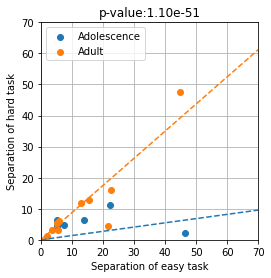

In [7]:
import statsmodels.api as sm
fig,ax=plt.subplots(1,1,figsize=(4,4))
plt.scatter(easy_ado,hard_ado,label='Adolescence')
ols = sm.RLM(hard_ado,easy_ado)
ols_result = ols_result_ado = ols.fit()
b1=ols_result.params[0]
s1=ols_result.bse
plt.plot([0,180],[0,180*ols_result.params[0]],'--')
plt.scatter(easy_adu,hard_adu,label='Adult')
ols = sm.RLM(hard_adu,easy_adu)
ols_result = ols_result_adu = ols.fit()
b2=ols_result.params[0]
s2=ols_result.bse
plt.plot([0,70],[0,70*ols_result.params[0]],'--')
z=(b1-b2)/np.sqrt(s1**2+s2**2)
plt.title('p-value:%0.2e'%scipy.stats.norm.sf(abs(z)))
plt.legend()
plt.xlim(0,70)
plt.ylim(0,70)
plt.xlabel('Separation of easy task')
plt.ylabel('Separation of hard task')
ax.set_box_aspect(1)
plt.grid()

# acc experiments

In [8]:
ev_list=['times_vec_hit_easy','times_vec_CR_easy','times_vec_hit_hard','times_vec_CR_hard']
lda_acc_multisession=partial(lda_acc,event_list=ev_list,
       bin_min=0,bin_max=0.2,n=1,window_size=2,cpu=1,subsample=None,subsample_event=None,cv=100,test_size_per_class=10)

In [9]:
def temp_func(i):
    return lda_acc_multisession([session_list_ado[i],i])
with Pool(96) as p:
    results_ado=p.map(temp_func,np.arange(len(session_list_ado)))
def temp_func(i):
    return lda_acc_multisession([session_list_adu[i],i])
with Pool(96) as p:
    results_adu=p.map(temp_func,np.arange(len(session_list_adu)))

In [10]:
results_ado=np.array(results_ado)
results_adu=np.array(results_adu)
results_ado=np.array(results_ado).mean(axis=-1)
results_adu=np.array(results_adu).mean(axis=-1)
results_all=np.concatenate([results_ado,results_adu])
task_id_ado=np.zeros(results_ado.shape)
task_id_ado[:,1]=1
task_id_adu=np.zeros(results_adu.shape)
task_id_adu[:,1]=1
task_id_all=np.concatenate([task_id_ado,task_id_adu])
adoadu=np.concatenate([np.zeros(results_ado.shape),np.ones(results_adu.shape)])
df=pd.DataFrame({'acc':results_all.reshape(-1),'task':task_id_all.reshape(-1),'type':adoadu.reshape(-1)})

In [11]:
print(scipy.stats.ttest_ind(results_ado[:,0],results_adu[:,0]))
print(scipy.stats.ttest_rel(results_ado[:,0],results_ado[:,1]))
print(scipy.stats.ttest_ind(results_ado[:,1],results_adu[:,1]))
print(scipy.stats.ttest_rel(results_adu[:,0],results_adu[:,1]))

Ttest_indResult(statistic=-0.6828899142148737, pvalue=0.5044449871392211)
Ttest_relResult(statistic=3.342773155536388, pvalue=0.012372576796287225)
Ttest_indResult(statistic=-2.422144315670308, pvalue=0.027670921905432366)
Ttest_relResult(statistic=4.024567276967917, pvalue=0.002997379084748151)


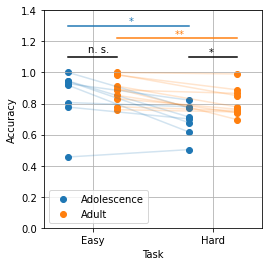

In [12]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.scatter(np.zeros(len(results_ado[:,0]))-0.2,results_ado[:,0],color='C0',label='Adolescence')
ax.scatter(np.zeros(len(results_adu[:,0]))+0.2,results_adu[:,0],color='C1',label='Adult')

for i in range(len(results_ado)):
    ax.plot([-0.2,0.8],[results_ado[i,0],results_ado[i,1]],color='C0',alpha=.2)
    
for i in range(len(results_adu)):
    ax.plot([0.2,1.2],[results_adu[i,0],results_adu[i,1]],color='C1',alpha=.2)

ax.scatter(np.ones(len(results_ado[:,0]))-0.2,results_ado[:,1],color='C0')
ax.scatter(np.ones(len(results_adu[:,0]))+0.2,results_adu[:,1],color='C1')
plt.xticks([0,1],labels=["Easy","Hard"])
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.ylim(0,1.4)
plt.plot([-0.2,0.2],[1.1,1.1],'k')
plt.text(-0.04,1.13,'n. s.')
plt.plot([0.8,1.2],[1.1,1.1],'k')
plt.text(1.0-0.04,1.11,'*')
plt.xlim(-0.4,1.4)
plt.plot([-0.2,0.8],[1.3,1.3],'C0')
plt.text(0.3,1.31,'*',color='C0')
plt.plot([0.2,1.2],[1.22,1.22],'C1')
plt.text(0.68,1.23,'**',color='C1')
plt.grid()
plt.legend(loc='lower left')
ax.set_box_aspect(1)

In [13]:
#last 0.2 s

In [14]:
ev_list=['times_vec_hit_easy','times_vec_CR_easy','times_vec_hit_hard','times_vec_CR_hard']
lda_acc_multisession=partial(lda_acc,event_list=ev_list,
       bin_min=2.0,bin_max=2.2,n=1,window_size=5,cpu=1,subsample=None,subsample_event=None,cv=100,test_size_per_class=10)

In [15]:
def temp_func(i):
    return lda_acc_multisession([session_list_ado[i],i])
with Pool(96) as p:
    results_ado=p.map(temp_func,np.arange(len(session_list_ado)))
def temp_func(i):
    return lda_acc_multisession([session_list_adu[i],i])
with Pool(96) as p:
    results_adu=p.map(temp_func,np.arange(len(session_list_adu)))

In [16]:
results_ado=np.array(results_ado)
results_adu=np.array(results_adu)
results_ado=np.array(results_ado).mean(axis=-1)
results_adu=np.array(results_adu).mean(axis=-1)
results_all=np.concatenate([results_ado,results_adu])
task_id_ado=np.zeros(results_ado.shape)
task_id_ado[:,1]=1
task_id_adu=np.zeros(results_adu.shape)
task_id_adu[:,1]=1
task_id_all=np.concatenate([task_id_ado,task_id_adu])
adoadu=np.concatenate([np.zeros(results_ado.shape),np.ones(results_adu.shape)])
df=pd.DataFrame({'acc':results_all.reshape(-1),'task':task_id_all.reshape(-1),'type':adoadu.reshape(-1)})

In [17]:
print(scipy.stats.ttest_ind(results_ado[:,0],results_adu[:,0]))
print(scipy.stats.ttest_rel(results_ado[:,0],results_ado[:,1]))
print(scipy.stats.ttest_ind(results_ado[:,1],results_adu[:,1]))
print(scipy.stats.ttest_rel(results_adu[:,0],results_adu[:,1]))

Ttest_indResult(statistic=-1.2814949472619594, pvalue=0.218280967205716)
Ttest_relResult(statistic=1.3980061042436287, pvalue=0.20481367810695744)
Ttest_indResult(statistic=-0.7417349794148199, pvalue=0.4689966898553013)
Ttest_relResult(statistic=2.0273287733694367, pvalue=0.07324986436828698)


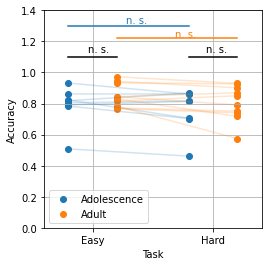

In [18]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.scatter(np.zeros(len(results_ado[:,0]))-0.2,results_ado[:,0],color='C0',label='Adolescence')
ax.scatter(np.zeros(len(results_adu[:,0]))+0.2,results_adu[:,0],color='C1',label='Adult')

for i in range(len(results_ado)):
    ax.plot([-0.2,0.8],[results_ado[i,0],results_ado[i,1]],color='C0',alpha=.2)
    
for i in range(len(results_adu)):
    ax.plot([0.2,1.2],[results_adu[i,0],results_adu[i,1]],color='C1',alpha=.2)

ax.scatter(np.ones(len(results_ado[:,0]))-0.2,results_ado[:,1],color='C0')
ax.scatter(np.ones(len(results_adu[:,0]))+0.2,results_adu[:,1],color='C1')

plt.xticks([0,1],labels=["Easy","Hard"])
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.ylim(0,1.4)
plt.plot([-0.2,0.2],[1.1,1.1],'k')
plt.text(-0.04,1.13,'n. s.')
plt.plot([0.8,1.2],[1.1,1.1],'k')
plt.text(1.0-0.06,1.13,'n. s.')
plt.xlim(-0.4,1.4)
plt.plot([-0.2,0.8],[1.3,1.3],'C0')
plt.text(0.28,1.32,'n. s.',color='C0')
plt.plot([0.2,1.2],[1.22,1.22],'C1')
plt.text(0.68,1.23,'n. s.',color='C1')
plt.grid()
plt.legend(loc='lower left')
ax.set_box_aspect(1)

In [ ]:
meta_list2=[]
sample_x=np.linspace(-0.6,10.0,213)
for t0 in tqdm(sample_x):
    ev_list=['times_vec_hit_easy','times_vec_CR_easy','times_vec_hit_hard','times_vec_CR_hard']
#     ev_list=['times_vec_go_easy','times_vec_no_go_easy','times_vec_go_hard','times_vec_no_go_hard']
    lda_acc_multisession=partial(lda_acc,event_list=ev_list,
           bin_min=t0,bin_max=t0+0.05,n=1,window_size=20,cpu=1,subsample=None,subsample_event=None,cv=50,test_size_per_class=10)
    def temp_func(i):
        return lda_acc_multisession([session_list_ado[i],i])
    with Pool(128) as p:
        results_ado=p.map(temp_func,np.arange(len(session_list_ado)))
    def temp_func(i):
        return lda_acc_multisession([session_list_adu[i],i])
    with Pool(128) as p:
        results_adu=p.map(temp_func,np.arange(len(session_list_adu)))
    results_ado=np.array(results_ado)
    results_adu=np.array(results_adu)
    results_ado=np.array(results_ado).mean(axis=-1)
    results_adu=np.array(results_adu).mean(axis=-1)
    meta_list2.append([results_ado,results_adu])

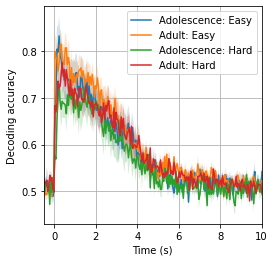

In [16]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
plt.plot(sample_x+0.025,np.array([i[0] for i in np.array(meta_list2)]).mean(axis=1)[:,0],label='Adolescence: Easy')
m=np.array([i[0] for i in np.array(meta_list2)]).mean(axis=1)[:,0]
std=np.array([i[0] for i in np.array(meta_list2)]).std(axis=1)[:,0]/np.sqrt(np.array([i[0] for i in np.array(meta_list2)]).shape[1]-1)
plt.fill_between(sample_x+0.025,m-std,m+std,alpha=.2)
plt.plot(sample_x+0.025,np.array([i[1] for i in np.array(meta_list2)]).mean(axis=1)[:,0],label='Adult: Easy')
m=np.array([i[1] for i in np.array(meta_list2)]).mean(axis=1)[:,0]
std=np.array([i[1] for i in np.array(meta_list2)]).std(axis=1)[:,0]/np.sqrt(np.array([i[1] for i in np.array(meta_list2)]).shape[1]-1)
plt.fill_between(sample_x+0.025,m-std,m+std,alpha=.2)


plt.plot(sample_x+0.025,np.array([i[0] for i in np.array(meta_list2)]).mean(axis=1)[:,1],label='Adolescence: Hard')
m=np.array([i[0] for i in np.array(meta_list2)]).mean(axis=1)[:,1]
std=np.array([i[0] for i in np.array(meta_list2)]).std(axis=1)[:,1]/np.sqrt(np.array([i[0] for i in np.array(meta_list2)]).shape[1]-1)
plt.fill_between(sample_x+0.025,m-std,m+std,alpha=.2)
plt.plot(sample_x+0.025,np.array([i[1] for i in np.array(meta_list2)]).mean(axis=1)[:,1],label='Adult: Hard')
m=np.array([i[1] for i in np.array(meta_list2)]).mean(axis=1)[:,1]
std=np.array([i[1] for i in np.array(meta_list2)]).std(axis=1)[:,1]/np.sqrt(np.array([i[1] for i in np.array(meta_list2)]).shape[1]-1)
plt.fill_between(sample_x+0.025,m-std,m+std,alpha=.2)


plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Decoding accuracy')
plt.xlim(-0.5,10.0)
plt.grid()
ax.set_box_aspect(1)

In [3]:
i=0
casual_time_list_ado=[]
for easy_hard in [0,1]:
    time_list=[]
    for j in [0,2,3,4,5,6,7]: #skip session 1 by d' criteria
        threshold=np.mean([a[i][j,easy_hard].mean() for a in meta_list2][:46])+3*np.std([a[i][j,easy_hard].mean() for a in meta_list2][:46])
        time_list.append(np.where(np.array([a[i][j,easy_hard].mean() for a in meta_list2])[46:]>threshold)[0][0]+46)
    casual_time_list_ado.append(sample_x[time_list]+0.05)
i=1
casual_time_list_adu=[]
for easy_hard in [0,1]:
    time_list=[]
    for j in range(10):
        threshold=np.mean([a[i][j,easy_hard].mean() for a in meta_list2][:46])+3*np.std([a[i][j,easy_hard].mean() for a in meta_list2][:46])
        time_list.append(np.where(np.array([a[i][j,easy_hard].mean() for a in meta_list2])[46:]>threshold)[0][0]+46)
    casual_time_list_adu.append(sample_x[time_list]+0.05)
casual_time_list_ado=np.array(casual_time_list_ado)
casual_time_list_adu=np.array(casual_time_list_adu)
results_ado=casual_time_list_ado.T*1000
results_adu=casual_time_list_adu.T*1000

In [4]:
print(scipy.stats.ttest_ind(results_ado[:,0],results_adu[:,0]))
print(scipy.stats.ttest_rel(results_ado[:,0],results_ado[:,1]))
print(scipy.stats.ttest_ind(results_ado[:,1],results_adu[:,1]))
print(scipy.stats.ttest_rel(results_adu[:,0],results_adu[:,1]))

TtestResult(statistic=2.650360426089298, pvalue=0.01817826512951784, df=15.0)
TtestResult(statistic=-3.690649742577593, pvalue=0.010200863500459772, df=6)
TtestResult(statistic=3.4811853448529755, pvalue=0.0033504196374905836, df=15.0)
TtestResult(statistic=-2.214962044894085, pvalue=0.054006234163812186, df=9)


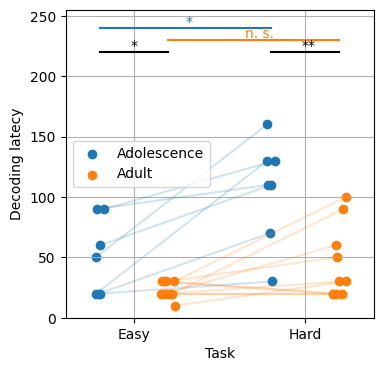

In [5]:

fig,ax=plt.subplots(1,1,figsize=(4,4))
noise1=0.02*np.random.randn(len(results_ado[:,0]))
noise2=0.02*np.random.randn(len(results_adu[:,0]))
ax.scatter(np.zeros(len(results_ado[:,0]))-0.2-noise1,results_ado[:,0],color='C0',label='Adolescence')
ax.scatter(np.zeros(len(results_adu[:,0]))+0.2-noise2,results_adu[:,0],color='C1',label='Adult')

for i in range(len(results_ado)):
    ax.plot([-0.2-noise1[i],0.8-noise1[i]],[results_ado[i,0],results_ado[i,1]],color='C0',alpha=.2)
    
for i in range(len(results_adu)):
    ax.plot([0.2-noise2[i],1.2-noise2[i]],[results_adu[i,0],results_adu[i,1]],color='C1',alpha=.2)

ax.scatter(np.ones(len(results_ado[:,0]))-0.2-noise1,results_ado[:,1],color='C0')
ax.scatter(np.ones(len(results_adu[:,0]))+0.2-noise2,results_adu[:,1],color='C1')


plt.xticks([0,1],labels=["Easy","Hard"])
plt.xlabel('Task')
plt.ylabel('Decoding latecy')
plt.ylim(0,255)
plt.plot([-0.2,0.2],[220,220],'k')
plt.text(-0.02,222,'*')
plt.plot([0.8,1.2],[220,220],'k')
plt.text(1.0-0.02,222,'**')
plt.xlim(-0.4,1.4)
plt.plot([-0.2,0.8],[240,240],'C0')
plt.text(0.3,242,'*',color='C0')
plt.plot([0.2,1.2],[230,230],'C1')
plt.text(0.65,232,'n. s.',color='C1')
plt.grid()
plt.legend()
ax.set_box_aspect(1)

# Variance analysis

In [5]:
lda_variance_multisession=partial(lda_variance,event_list=ev_list,
       bin_min=0,bin_max=0.2,n=1,window_size=2,cpu=1,subsample=None,subsample_event=None)
def temp_func(i):
    return lda_variance_multisession([session_list_ado[i],i])
with Pool(96) as p:
    results_ado=p.map(temp_func,np.arange(len(session_list_ado)))
def temp_func(i):
    return lda_variance_multisession([session_list_adu[i],i])
with Pool(96) as p:
    results_adu=p.map(temp_func,np.arange(len(session_list_adu)))

In [6]:
results_ado=np.array(results_ado)
results_adu=np.array(results_adu)
print(scipy.stats.ttest_rel((results_ado[:,0,0]+results_ado[:,0,1])/2,(results_ado[:,0,2]+results_ado[:,0,3])/2))
print(scipy.stats.ttest_rel((results_adu[:,0,0]+results_adu[:,0,1])/2,(results_adu[:,0,2]+results_adu[:,0,3])/2))
print(scipy.stats.ttest_ind((results_ado[:,0,0]+results_ado[:,0,1])/2,(results_adu[:,0,0]+results_adu[:,0,1])/2))
print(scipy.stats.ttest_ind((results_ado[:,0,2]+results_ado[:,0,3])/2,(results_adu[:,0,2]+results_adu[:,0,3])/2))

Ttest_relResult(statistic=-2.8134855043899405, pvalue=0.026015397672633615)
Ttest_relResult(statistic=-3.833769713283035, pvalue=0.004004538078442402)
Ttest_indResult(statistic=0.7761516751470611, pvalue=0.4489813251089513)
Ttest_indResult(statistic=0.8433255192901755, pvalue=0.41147726599692436)


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


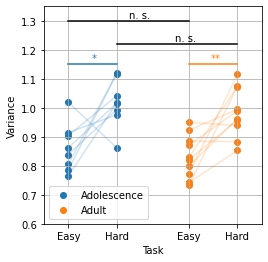

In [7]:
ado1,ado2=(results_ado[:,0,0]+results_ado[:,0,1])/2,(results_ado[:,0,2]+results_ado[:,0,3])/2
adu1,adu2=(results_adu[:,0,0]+results_adu[:,0,1])/2,(results_adu[:,0,2]+results_adu[:,0,3])/2


fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.scatter(np.zeros(len(ado1))-0.2,ado1,color='C0',label='Adolescence')
ax.scatter(np.zeros(len(ado2))+0.2,ado2,color='C0')

for i in range(len(results_ado)):
    ax.plot([-0.2,0.2],[ado1[i],ado2[i]],color='C0',alpha=.2)
    
for i in range(len(results_adu)):
    ax.plot([0.8,1.2],[adu1[i],adu2[i]],color='C1',alpha=.2)

ax.scatter(np.zeros(len(adu1))+0.8,adu1,color='C1',label='Adult')
ax.scatter(np.zeros(len(adu2))+1.2,adu2,color='C1')

plt.xticks([-0.2,0.2,0.8,1.2],labels=["Easy","Hard","Easy","Hard"])
plt.xlabel('Task')
plt.ylabel('Variance')
plt.ylim(0.6,1.35)
plt.plot([-0.2,0.2],[1.15,1.15],'C0')
plt.text(-0.01,1.16,'*',color='C0')
plt.plot([0.8,1.2],[1.15,1.15],'C1')
plt.text(1.0-0.02,1.16,'**',color='C1')
plt.xlim(-0.4,1.4)
plt.plot([-0.2,0.8],[1.3,1.3],'k')
plt.text(0.3,1.31,'n. s.',color='k')
plt.plot([0.2,1.2],[1.22,1.22],'k')
plt.text(0.68,1.23,'n. s.',color='k')
plt.grid()
plt.legend(loc='lower left')
ax.set_box_aspect(1)

In [8]:
lda_variance_multisession=partial(lda_variance_vis,event_list=ev_list,
       bin_min=0,bin_max=0.2,n=1,window_size=2,cpu=1,subsample=20,subsample_event=20)

In [9]:
def temp_func(i):
    return lda_variance_multisession([session_list_ado[i],i])
with Pool(96) as p:
    results_ado=p.map(temp_func,np.arange(len(session_list_ado)))
def temp_func(i):
    return lda_variance_multisession([session_list_adu[i],i])
with Pool(96) as p:
    results_adu=p.map(temp_func,np.arange(len(session_list_adu)))

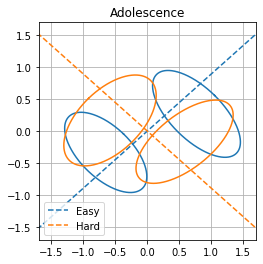

In [13]:
from matplotlib.patches import Ellipse
fig,ax=plt.subplots(1,1,figsize=(4,4))
for j in range(4):
    cov=np.array([i[1] for i in results_ado]).mean(axis=0)[j]
    eigenvalues,  eigenvectors=np.linalg.eig(cov)
    theta = np.linspace(0, 2*np.pi, 1000);
    ellipsis = (np.sqrt(eigenvalues[None,:]) * eigenvectors) @ [np.sin(theta), np.cos(theta)]+np.array([i[0] for i in results_ado]).mean(axis=0)[j,:,None]
    ax.plot(ellipsis[0,:], ellipsis[1,:],color='C%d'%(j//2))
for j in range(2):
    c1,c2=np.array([i[-1] for i in results_ado]).mean(axis=0)[j]
    ax.plot(np.linspace(-2,2,101),np.linspace(-2,2,101)/c1*c2,'--',label=['Easy','Hard'][j])

ax.set_xlim(-1.7,1.7)
ax.set_ylim(-1.7,1.7)
ax.legend(title='LDA dimension')
ax.set_title('Adolescence')
plt.grid()
plt.legend(loc='lower left')
ax.set_box_aspect(1)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


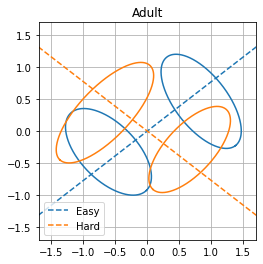

In [11]:
from matplotlib.patches import Ellipse
fig,ax=plt.subplots(1,1,figsize=(4,4))
for j in range(4):
    cov=np.array([i[1] for i in results_adu]).mean(axis=0)[j]
    eigenvalues,  eigenvectors=np.linalg.eig(cov)
    theta = np.linspace(0, 2*np.pi, 1000);
    ellipsis = (np.sqrt(eigenvalues[None,:]) * eigenvectors) @ [np.sin(theta), np.cos(theta)]+np.array([i[0] for i in results_adu]).mean(axis=0)[j,:,None]
    ax.plot(ellipsis[0,:], ellipsis[1,:],color='C%d'%(j//2))
for j in range(2):
    c1,c2=np.array([i[-1] for i in results_adu]).mean(axis=0)[j]
    ax.plot(np.linspace(-2,2,101),np.linspace(-2,2,101)/c1*c2,'--',label=['Easy','Hard'][j])
    
ax.set_xlim(-1.7,1.7)
ax.set_ylim(-1.7,1.7)
ax.legend(title='LDA dimension')
ax.set_title('Adult')
plt.grid()
plt.legend(loc='lower left')
ax.set_box_aspect(1)